# Smart Queue Monitoring System - Manufacturing Scenario

## Overview
Now that you have your Python script and job submission script, you're ready to request an **IEI Tank-870** edge node and run inference on the different hardware types (CPU, GPU, VPU, FPGA).

After the inference is completed, the output video and stats files need to be retrieved and stored in the workspace, which can then be viewed within the Jupyter Notebook.

## Objectives
* Submit inference jobs to Intel's DevCloud using the `qsub` command.
* Retrieve and review the results.
* After testing, go back to the proposal doc and update your original proposed hardware device.

## Step 0: Set Up

#### IMPORTANT: Set up paths so we can run Dev Cloud utilities
You *must* run this every time you enter a Workspace session.
(Tip: select the cell and use **Shift+Enter** to run the cell.)

In [1]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


### Step 0.1:  (Optional-step): Original Video

If you are curious to see the input video, run the following cell to view the original video stream we'll be using for inference.

In [2]:
import videoHtml
videoHtml.videoHTML('Manufacturing', ['original_videos/Manufacturing.mp4'])

## Step 1 : Inference on a Video

In the next few cells, You'll submit your job using the `qsub` command and retrieve the results for each job. Each of the cells below should submit a job to different edge compute nodes.

The output of the cell is the `JobID` of your job, which you can use to track progress of a job with `liveQStat`.

You will need to submit a job for each of the following hardware types:
* **CPU**
* **GPU**
* **VPU**
* **FPGA**

**Note:** You will have to submit each job one at a time and retrieve their results. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(Tip: **shift+enter** will run the cell and automatically move you to the next cell.)

If your job successfully runs and completes, once you retrieve your results, it should output a video and a stats text file in the `results/manufacturing/<DEVICE>` directory.

For example, your **CPU** job should output its files in this directory:
> **results/manufacturing/cpu**

**Note**: To get the queue labels for the different hardware devices, you can go to [this link](https://devcloud.intel.com/edge/get_started/devcloud/).

The following arguments should be passed to the job submission script after the `-F` flag:
* Model path - `/data/models/intel/person-detection-retail-0013/<MODEL PRECISION>/`. You will need to adjust this path based on the model precision being using on the hardware.
* Device - `CPU`, `GPU`, `MYRIAD`, `HETERO:FPGA,CPU`.
* Manufacturing video path - `/data/resources/manufacturing.mp4`.
* Manufacturing queue_param file path - `/data/queue_param/manufacturing.npy`.
* Output path - `/output/results/manufacturing/<DEVICE>` This should be adjusted based on the device used in the job.
* Max num of people - This is the max number of people in queue before the system would redirect them to another queue.

## Step 1.1: Submit to an Edge Compute Node with an Intel CPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500TE processor</a>. The inference workload should run on the CPU.

In [3]:
#Submit job to the queue
cpu_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te -F "/data/models/intel/person-detection-retail-0013/FP32/person-detection-retail-0013 CPU /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/cpu 5" -N store_core
print(cpu_job_id[0])

gOp7iU2x4e9l0UBMMzIgYjCDWeztAZgp


#### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [4]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [5]:
import get_results
get_results.getResults(cpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:gOp7iU2x4e9l0UBMMzIgYjCDWeztAZgp) are ready.
Please wait.....................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [6]:
!tar zxf output.tgz

In [7]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/cpu/
results/manufacturing/cpu/stats.txt
results/manufacturing/cpu/output_video.mp4
stderr.log


#### View stderr.log
This can be used for debugging.

In [8]:
!cat stderr.log

#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [9]:
import videoHtml

videoHtml.videoHTML('Manufacturing CPU', ['results/manufacturing/cpu/output_video.mp4'])

## Step 1.2: Submit to an Edge Compute Node with CPU and IGPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload should run on the **Intel® HD Graphics 530** integrated GPU.

In [10]:
#Submit job to the queue
gpu_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 GPU /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/gpu 5" -N store_core

print(gpu_job_id[0])

FfwHEZbMalG1nonZUaDTfYc6UN056sgL


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [11]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [12]:
import get_results
get_results.getResults(gpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:FfwHEZbMalG1nonZUaDTfYc6UN056sgL) are ready.
Please wait...........................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [13]:
!tar zxf output.tgz

In [14]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/gpu/
results/manufacturing/gpu/stats.txt
results/manufacturing/gpu/output_video.mp4
stderr.log


#### View stderr.log
This can be used for debugging.

In [15]:
!cat stderr.log

#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [16]:
import videoHtml

videoHtml.videoHTML('Manufacturing GPU', ['results/manufacturing/gpu/output_video.mp4'])

## Step 1.3: Submit to an Edge Compute Node with a Neural Compute Stick 2
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload should run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [17]:
#Submit job to the queue
vpu_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 MYRIAD /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/vpu 5" -N store_core

print(vpu_job_id[0])

ubuCCOKlPMwWLJc1oDaGOwiWuj8BcHdc


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [18]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [19]:
import get_results
get_results.getResults(vpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:ubuCCOKlPMwWLJc1oDaGOwiWuj8BcHdc) are ready.
Please wait..............................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [20]:
!tar zxf output.tgz

In [21]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/vpu/
results/manufacturing/vpu/stats.txt
results/manufacturing/vpu/output_video.mp4
stderr.log


#### View stderr.log
This can be used for debugging.

In [22]:
!cat stderr.log

#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [23]:
import videoHtml

videoHtml.videoHTML('Manufacturing VPU', ['results/manufacturing/vpu/output_video.mp4'])

In [24]:
cpu_vpu_job_id_core = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 MULTI:CPU,MYRIAD /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/cpu-vpu 5" -N store_core
print(cpu_vpu_job_id_core[0])

TxbMlGU8xRXBj42tSOpwuhLQC4aqmAm4


In [25]:
import liveQStat
liveQStat.liveQStat()

In [26]:
import get_results
get_results.getResults(cpu_vpu_job_id_core[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:TxbMlGU8xRXBj42tSOpwuhLQC4aqmAm4) are ready.
Please wait........................Success!
output.tgz was downloaded in the same folder as this notebook.


In [27]:
!tar zxf output.tgz

In [28]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/cpu-vpu/
results/manufacturing/cpu-vpu/stats.txt
results/manufacturing/cpu-vpu/output_video.mp4
stderr.log


In [29]:
!cat stderr.log

In [30]:
import videoHtml

videoHtml.videoHTML('Manufacturing MULTI:CPU,MYRIAD', ['results/manufacturing/cpu-vpu/output_video.mp4'])

In [31]:
gpu_vpu_job_id_core = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-hd-530:intel-ncs2 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 MULTI:GPU,MYRIAD /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/gpu-vpu 5" -N store_core
print(gpu_vpu_job_id_core[0])

XrYHF6wRbLX5LNHatWnphP4X1esxsdWj


In [32]:
import liveQStat
liveQStat.liveQStat()

In [33]:
import get_results
get_results.getResults(gpu_vpu_job_id_core[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:XrYHF6wRbLX5LNHatWnphP4X1esxsdWj) are ready.
Please wait....................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [34]:
!tar zxf output.tgz

In [35]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/gpu-vpu/
results/manufacturing/gpu-vpu/stats.txt
results/manufacturing/gpu-vpu/output_video.mp4
stderr.log


In [36]:
!cat stderr.log

In [37]:
import videoHtml

videoHtml.videoHTML('Manufacturing MULTI:GPU,MYRIAD', ['results/manufacturing/gpu-vpu/output_video.mp4'])

In [38]:
cpu_gpu_vpu_job_id_core = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:intel-hd-530:intel-ncs2 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 MULTI:CPU,GPU,MYRIAD /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/cpu-gpu-vpu 5" -N store_core
print(cpu_gpu_vpu_job_id_core[0])

x1ircvVhYsvFPx0ZP89b6GCTv52k2ez5


In [39]:
import liveQStat
liveQStat.liveQStat()

In [40]:
import get_results
get_results.getResults(cpu_gpu_vpu_job_id_core[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:x1ircvVhYsvFPx0ZP89b6GCTv52k2ez5) are ready.
Please wait....................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [41]:
!tar zxf output.tgz

In [42]:
!cat stdout.log

draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 8
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/cpu-gpu-vpu/
results/manufacturing/cpu-gpu-vpu/stats.txt
results/manufacturing/cpu-gpu-vpu/output_video.mp4
stderr.log


In [43]:
!cat stderr.log

In [44]:
import videoHtml

videoHtml.videoHTML('Manufacturing MULTI:CPU,GPU,MYRIAD', ['results/manufacturing/cpu-gpu-vpu/output_video.mp4'])

## Step 1.4: Submit to an Edge Compute Node with IEI Mustang-F100-A10
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> FPGA card installed in this node.

In [45]:
#Submit job to the queue
fpga_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 HETERO:FPGA,CPU /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/fpga-cpu 5" -N store_core

print(fpga_job_id[0])

altlEecGlyJPSA1N58a2baCcMiM7Qp3T


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [46]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [47]:
import get_results
get_results.getResults(fpga_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:altlEecGlyJPSA1N58a2baCcMiM7Qp3T) are ready.
Please wait...............................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [48]:
!tar zxf output.tgz

In [49]:
!cat stdout.log

INTELFPGAOCLSDKROOT is not set
Using script's current directory (/opt/altera/aocl-pro-rte/aclrte-linux64)

aoc was not found, but aocl was found. Assuming only RTE is installed.

AOCL_BOARD_PACKAGE_ROOT is set to /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2. Using that.
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/bin to PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/linux64/lib to LD_LIBRARY_PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/host/linux64/lib to LD_LIBRARY_PATH
Adding /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/lib to LD_LIBRARY_PATH
aocl program: Running program from /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/libexec
Programming device: a10gx_2ddr : Intel Vision Accelerator Design with Intel Arria 10 FPGA (acla10_1150_sg20)
Program succeed. 
draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
To

#### View stderr.log
This can be used for debugging.

In [50]:
!cat stderr.log

#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [51]:
import videoHtml

videoHtml.videoHTML('Manufacturing FPGA', ['results/manufacturing/fpga-cpu/output_video.mp4'])

In [52]:
#Submit job to the queue
gpu_cpu_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 HETERO:GPU,CPU /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/h-gpu-cpu 5" -N store_core

print(gpu_cpu_job_id[0])

XkxDT7OHBrx9PkK02Yr0S1eSccAotXke


In [53]:
import liveQStat
liveQStat.liveQStat()

In [54]:
import get_results
get_results.getResults(gpu_cpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:XkxDT7OHBrx9PkK02Yr0S1eSccAotXke) are ready.
Please wait....................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [55]:
!tar zxf output.tgz

In [56]:
!cat stdout.log

mbox_conf1/out/conv/flat/softmax/flat is CPU
mbox_conf1/out/conv/flat/reshape is GPU
mbox_conf1/out/conv/flat is GPU
mbox_conf1/out/conv/perm is GPU
mbox_loc1/out/conv/flat is CPU
mbox_loc1/out/conv/perm is CPU
mbox_conf1/out/conv/flat/Cast_139070_const is GPU
mbox_conf1/out/conv/flat/reshape/Cast_139084_const is GPU
mbox_conf1/out/conv/flat/softmax/flat/Cast_139096_const is CPU
mbox_loc1/out/conv/flat/Cast_139290_const is CPU
draw_outputs
Total People in frame = 7
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 8
Number of people in queue = {1: 1, 2: 1}
draw_outputs
Total People in frame = 0
Number of people in queue = {1: 0, 2: 0}
results/
results/manufacturing/
results/manufacturing/h-gpu-cpu/
results/manufacturing/h-gpu-cpu/stats.txt
results/manufacturing/h-gpu-cpu/output_video.mp4
stderr.log


In [57]:
!cat stderr.log

In [58]:
import videoHtml

videoHtml.videoHTML('Manufacturing GPU-CPU', ['results/manufacturing/h-gpu-cpu/output_video.mp4'])

In [59]:
#Submit job to the queue
fpga_gpu_cpu_job_id = !qsub queue_job.sh -d . -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013 HETERO:FPGA,GPU,CPU /data/resources/manufacturing.mp4 /data/queue_param/manufacturing.npy /output/results/manufacturing/fpga-gpu-cpu 5" -N store_core

print(fpga_gpu_cpu_job_id[0])

sG15YzjA8XeZgPja1jZ0O3ClXpp28lb5


In [60]:
import liveQStat
liveQStat.liveQStat()

In [61]:
import get_results
get_results.getResults(fpga_gpu_cpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:sG15YzjA8XeZgPja1jZ0O3ClXpp28lb5) are ready.
Please wait.............................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [62]:
!tar zxf output.tgz

In [63]:
!cat stdout.log

INTELFPGAOCLSDKROOT is not set
Using script's current directory (/opt/altera/aocl-pro-rte/aclrte-linux64)

aoc was not found, but aocl was found. Assuming only RTE is installed.

AOCL_BOARD_PACKAGE_ROOT is set to /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2. Using that.
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/bin to PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/linux64/lib to LD_LIBRARY_PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/host/linux64/lib to LD_LIBRARY_PATH
Adding /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/lib to LD_LIBRARY_PATH
aocl program: Running program from /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/libexec
Programming device: a10gx_2ddr : Intel Vision Accelerator Design with Intel Arria 10 FPGA (acla10_1150_sg20)
Program succeed. 
mbox_conf1/out/conv/flat/softmax/flat is CPU
mbox_conf1/out/conv/flat/reshape is GPU
mbox_conf1

In [64]:
!cat stderr.log

In [65]:
import videoHtml

videoHtml.videoHTML('Manufacturing FPGA-GPU-CPU', ['results/manufacturing/fpga-gpu-cpu/output_video.mp4'])

***Wait!***

Please wait for all the inference jobs and video rendering to complete before proceeding to the next step.

## Step 2: Assess Performance

Run the cells below to compare the performance across all 4 devices. The following timings for the model are being compared across all 4 devices:

- Model Loading Time
- Average Inference Time
- FPS

In [70]:
import matplotlib.pyplot as plt
import numpy as np


device_list=['cpu', 'gpu', 'vpu', 'cpu-vpu', 'gpu-vpu', 'cpu-gpu-vpu', 'h-gpu-cpu', 'fpga-cpu', 'fpga-gpu-cpu']
inference_time=[]
fps=[]
model_load_time=[]

for i, device in enumerate(device_list):
    with open('results/manufacturing/'+device+'/stats.txt', 'r') as f:
        inference_time.append(float(f.readline().split("\n")[0]))
        fps.append(float(f.readline().split("\n")[0]))
        model_load_time.append(float(f.readline().split("\n")[0]))

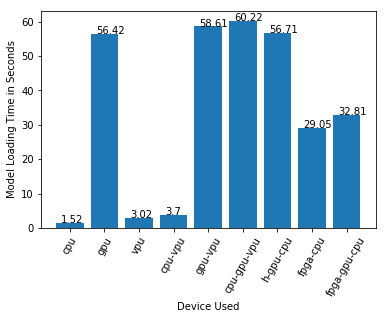

In [71]:
plt.bar(range(len(device_list)), list(map(float,model_load_time)) )
plt.xticks(range(len(device_list)), device_list, rotation=60)
plt.xlabel("Device Used")
plt.ylabel("Model Loading Time in Seconds")
for i, v in enumerate(model_load_time):
    value = np.round(v,decimals=2)
    plt.text(i - 0.25, v + 0.01, str(value))
plt.show()

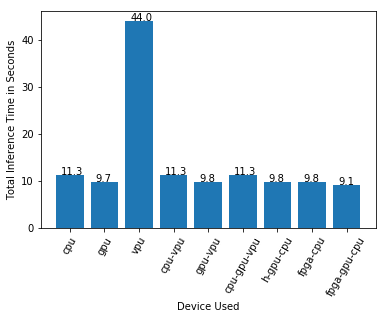

In [72]:
plt.bar(range(len(device_list)), list(map(float,inference_time)) )
plt.xticks(range(len(device_list)), device_list, rotation=60)
plt.xlabel("Device Used")
plt.ylabel("Total Inference Time in Seconds")
for i, v in enumerate(inference_time):
    value = np.round(v,decimals=2)
    plt.text(i - 0.25, v + 0.01, str(value))
plt.show()

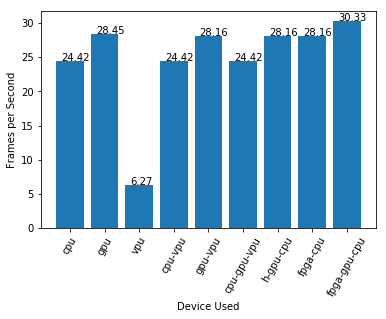

In [73]:
plt.bar(range(len(device_list)), list(map(float,fps)) )
plt.xticks(range(len(device_list)), device_list, rotation=60)
plt.xlabel("Device Used")
plt.ylabel("Frames per Second")
# plt.xticks(device_list, rotation=60)
for i, v in enumerate(fps):
    value = np.round(v,decimals=2)
    plt.text(i - 0.25, v + 0.01, str(value))
plt.show()

# Step 3: Update Proposal Document

Now that you've completed your hardware testing, you should go back to the proposal document and validate or update your originally proposed hardware. Once you've updated your proposal, you can move on to the next scenario.